## 『本次練習內容』
#### 學習如何搭建Inception Block

## 『本次練習目的』
  #### 了解Inceotion原理
  #### 了解如何導入Inception block到原本架構中

---

![Incpeiton](Inception架構.png)

In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras import backend as K
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Activation

Using TensorFlow backend.


## 導入InceptionV2-有BatchNormalization的Convolution

In [0]:
def Conv2d_bn(x,filters,kernel_size,padding='same',strides=(1, 1),normalizer=True,activation='relu',name=None):
    if name is not None:
        conv_name = name + '_conv'
        bn_name = name + '_bn'
        act_name = name + '_act'
    else:
        conv_name = None
        bn_name = None
        act_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
            filters, kernel_size,
            strides=strides, padding=padding,
            use_bias=False, name=conv_name)(x)
    if normalizer:
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation:
        x = Activation(activation, name=act_name)(x)
    return x

## 參考上圖搭建 InceptionV1_block


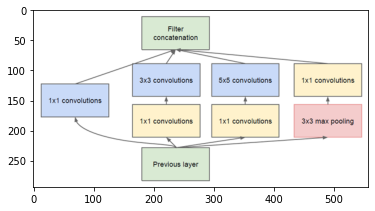

In [3]:
!pip install --user opencv-python

%matplotlib inline
from matplotlib import pyplot as plt

import cv2

img_path = 'InceptionV1_block.png'

# 以彩色圖片的方式載入
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [0]:
def InceptionV1_block(x, specs,channel_axis, name):
    (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))
    branch_0 = Conv2d_bn(x, br0[0], (1, 1), name=name+"_Branch_0")

    branch_1 = Conv2d_bn(x, br1[0], (1, 1), name=name+"_Branch_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (3, 3), name=name+"_Branch_1_1")

    '''Branch_2'''
    branch_2 = Conv2d_bn(x, br2[0], (1, 1), name=name+"_Branch_2")
    branch_2 = Conv2d_bn(branch_2, br2[1], (5, 5), name=name+"_Branch_2_1")

    '''Branch_3'''
    branch_3 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name=name+"_Branch_3")(x)
    branch_3 = Conv2d_bn(branch_3, br3[0], (1, 1), name=name+"_Branch_3_1")
    

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name=name+"_Concatenated")
    return x

## 測試

In [5]:
img_input = Input(shape=(224,224,1))
x=InceptionV1_block(img_input, ((64,), (96,128), (16,32), (32,)), 3, 'Block_1')
print(x)













Tensor("Block_1_Concatenated/concat:0", shape=(?, 224, 224, 256), dtype=float32)


## 將 InceptionV1_block中n*n卷積改為1 x n+n x 1

In [0]:
def InceptionV3_block(x, specs,channel_axis, name):
    (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))
    branch_0 = Conv2d_bn(x, br0[0], (1, 1), name=name+"_Branch_0")

    branch_1 = Conv2d_bn(x, br1[0], (1, 1), name=name+"_Branch_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (1, 3), name=name+"_Branch_1_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (3, 1), name=name+"_Branch_1_2")

    '''Branch_2'''
    branch_2 = Conv2d_bn(x, br2[0], (1, 1), name=name+"_Branch_2")
    branch_2 = Conv2d_bn(branch_2, br2[1], (1, 5), name=name+"_Branch_2_1")
    branch_2 = Conv2d_bn(branch_2, br2[1], (5, 1), name=name+"_Branch_2_2")

    '''Branch_3'''
    branch_3 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name=name+"_Branch_3")(x)
    branch_3 = Conv2d_bn(branch_3, br3[0], (1, 1), name=name+"_Branch_3_1")

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name=name+"_Concatenated")
    return x

## 測試

In [7]:
img_input = Input(shape=(224,224,1))
x=InceptionV3_block(img_input, ((64,), (96,128), (16,32), (32,)), 3, 'Block_1')
print(x)

Tensor("Block_1_Concatenated_1/concat:0", shape=(?, 224, 224, 256), dtype=float32)


---

## 額外練習

## 將VGG16 Block_3中的Convolution全部改為InceptionV1_block
## Block_5中的Convolution全部改為InceptionV3_block
## 並將所有Convolution改為Conv2d_bn

#### 原vgg16架構

In [0]:


def VGG16(include_top=True,input_tensor=None, input_shape=(224,224,1),
          pooling='max',classes=1000):
 
    img_input = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

   
    return model



#### 修改後

In [0]:
def VGG16_Inception(include_top=True,input_tensor=None, input_shape=(224,224,1),
          pooling='max',classes=1000):
 
    '''修改模型'''
   
    return model



In [0]:
model = VGG16_Inception(include_top=False)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1_conv (Conv2D)      (None, 224, 224, 64) 576         input_19[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 224, 224, 64) 192         block1_conv1_conv[0][0]          
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 224, 224, 64) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con